In [1]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input, SimpleRNN
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score


In [2]:

ticker = 'KRKA.BE'
start_date = '2005-01-01'
end_date = '2023-01-01'
stock_data = yf.download(ticker, start=start_date, end=end_date)
print(stock_data)
print(stock_data.columns)

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Ticker        KRKA.BE    KRKA.BE    KRKA.BE    KRKA.BE KRKA.BE
Date                                                          
2018-08-15   8.152894   8.152894   8.152894   8.152894       0
2018-08-16   8.754466   8.754466   8.754466   8.754466       0
2018-08-17   8.429933   8.429933   8.429933   8.429933       0
2018-08-20   8.524920   8.524920   8.524920   8.524920       0
2018-08-21   8.437849   8.437849   8.437849   8.437849       0
...               ...        ...        ...        ...     ...
2022-12-23  18.044550  18.044550  17.856585  17.950568       0
2022-12-27  17.950567  18.420477  17.856585  17.950567       0
2022-12-28  18.326494  19.172332  17.856584  18.138529       0
2022-12-29  19.172333  19.172333  18.420477  18.514460       0
2022-12-30  19.548260  19.736224  19.360297  19.360297       0

[1111 rows x 5 columns]
MultiIndex([( 'Close', 'KRKA.BE'),
            (  'High', 'KRKA.BE'),
            (   'Low', 

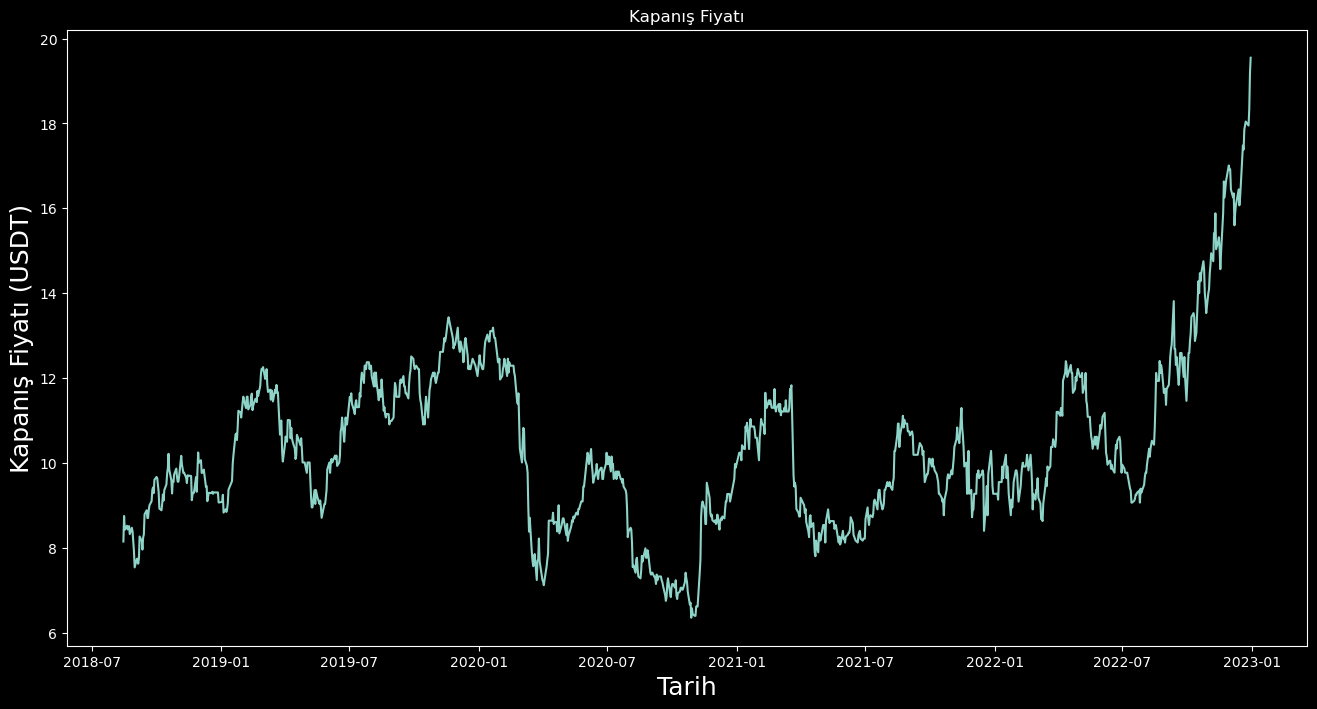

In [3]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 8))
plt.title('Kapanış Fiyatı')
plt.plot(stock_data['Close'])
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı (USDT)', fontsize=18)
plt.show()

In [4]:
#MODEL EĞİTİMİNE VERİYİ HAZIRLAMA
stock_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
data = stock_data.filter(['Close'])

#eksik değerleri kaldırıyoruz
if data.isnull().sum().sum() > 0:
    data = data.dropna()

print(data.head())
print(data.shape)

#veriyi modelin eğitilmesi için uygunhale getiriyoruz
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


               Close
Date                
2018-08-15  8.152894
2018-08-16  8.754466
2018-08-17  8.429933
2018-08-20  8.524920
2018-08-21  8.437849
(1111, 1)


In [5]:
#Test ve Eğitim verilerini ayırma 
training_data_len = int(len(dataset) * 0.8)
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [6]:
#Eğitim verisini eğitmeye uygun hale getiriyoruz girdi ve çıktıları hazırlıyoruz
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:

model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1))) 
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(90, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=15)

Epoch 1/15


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


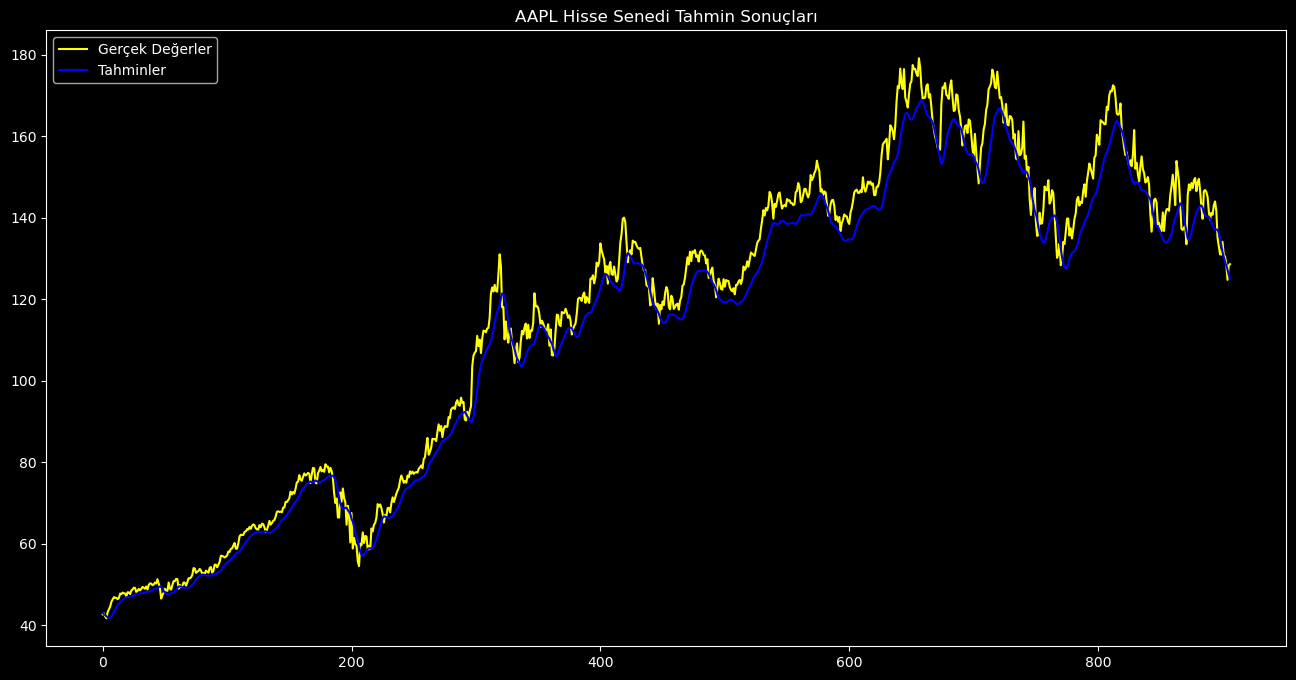

In [51]:
#TEST Katmanı
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#model tahminleri
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
valid = pd.DataFrame({'Close': dataset[training_data_len:, 0], 'Predictions': predictions.flatten()})


plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Hisse Senedi Tahmin Sonuçları')
plt.plot(valid['Close'], color='yellow', label='Gerçek Değerler')
plt.plot(valid.index, predictions, color='blue', label='Tahminler')
plt.legend(loc='upper left')
plt.show()


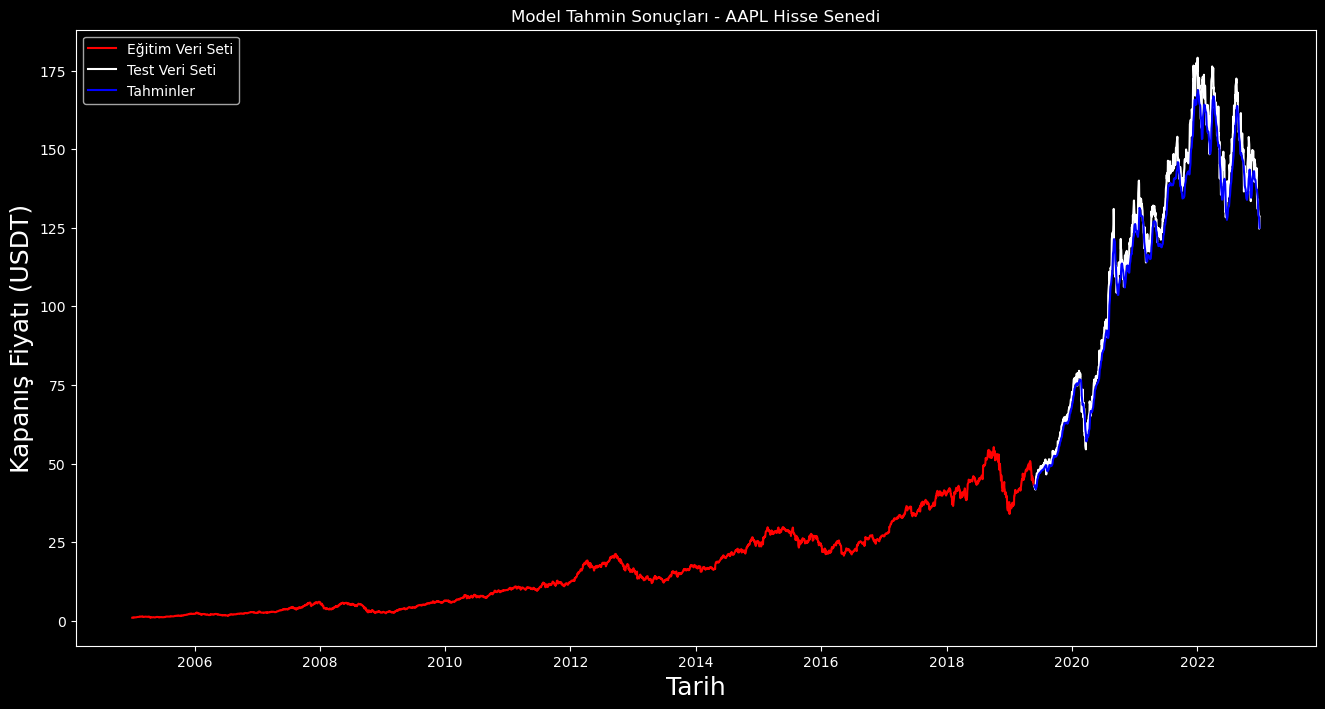

In [53]:
#EĞİTİM TEST VE TAHMİN SONUÇLARINI BİR ARADA GÖRSELLEŞTİRMEK İÇİN
train = data[:training_data_len]
valid = data[training_data_len:].copy()  # 


valid.loc[:, 'predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model Tahmin Sonuçları - AAPL Hisse Senedi')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı (USDT)', fontsize=18)

plt.plot(train['Close'], color='red', label='Eğitim Veri Seti')
plt.plot(valid['Close'], color='white', label='Test Veri Seti')
plt.plot(valid['predictions'], color='blue', label='Tahminler')

plt.legend(loc='upper left')  
plt.show()


In [55]:
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['predictions'] = predictions

In [57]:
print(valid.tail(15))

                 Close  predictions
Date                               
2022-12-09  140.680618   138.096466
2022-12-12  142.986343   137.390945
2022-12-13  143.956192   137.060791
2022-12-14  141.719681   137.078735
2022-12-15  135.079514   137.039413
2022-12-16  133.110199   136.248062
2022-12-19  130.992462   134.923599
2022-12-20  130.923218   133.230881
2022-12-21  134.040451   131.523849
2022-12-22  130.853943   130.345306
2022-12-23  130.487793   129.240097
2022-12-27  128.676865   128.259720
2022-12-28  124.728371   127.262039
2022-12-29  128.261215   125.937294
2022-12-30  128.577866   124.974785


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
AAPL için 1 ay sonraki fiyat: 124.35758209228516
Ortalama Kare Hata (MSE): 34.47
Kök Ortalama Kare Hata (RMSE): 5.87
Ortalama Mutlak Hata (MAE): 4.67
R² Skoru: 0.98


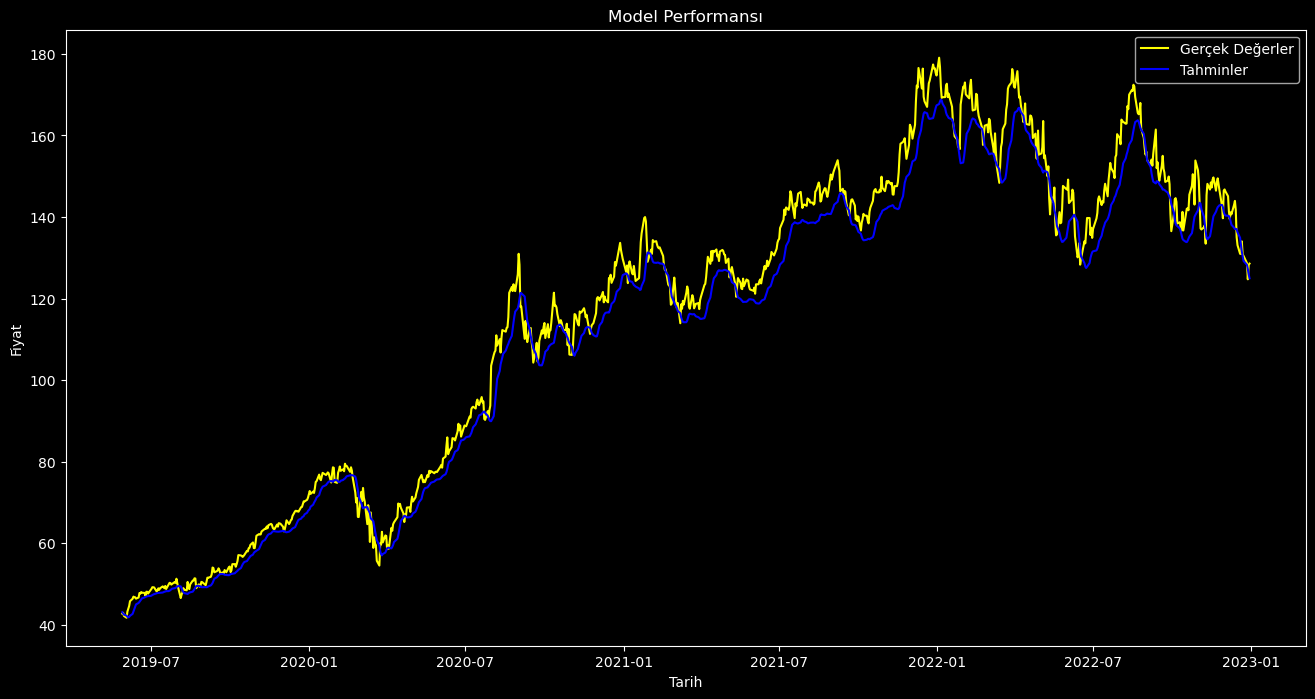

In [59]:

last_60_days = scaled_data[-60:]
X_test = np.array([last_60_days])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price_1months = model.predict(X_test)
pred_price_1months = scaler.inverse_transform(pred_price_1months)
print(f'{ticker} için 1 ay sonraki fiyat: {pred_price_1months[0][0]}')




y_true = valid['Close'].values
y_pred = valid['predictions'].values


mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)


r2 = r2_score(y_true, y_pred)


print(f"Ortalama Kare Hata (MSE): {mse:.2f}")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse:.2f}")
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f}")
print(f"R² Skoru: {r2:.2f}")




plt.figure(figsize=(16, 8))
plt.plot(valid['Close'], label='Gerçek Değerler', color='yellow')
plt.plot(valid['predictions'], label='Tahminler', color='blue')
plt.title('Model Performansı')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

